# Triples (or higher order) systems in each samples

In [1]:
import sys
sys.path.append('../src')
import os
import P_binary
import P_random
import P_posterior
import parallax
import const as c
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import corner
import pickle


%matplotlib inline

### Read in samples

In [93]:
dtype = [('P_posterior','f8'), ('theta','f8'), ('distance','f8'), ('proj_sep','f8'),
         ('source_id_1','<u8'), ('TYC_id_1','S11'), ('hip_id_1','<i8'),
         ('ra_1','f8'), ('dec_1','f8'),
         ('mu_ra_1','f8'), ('mu_dec_1','f8'), ('mu_ra_err_1','f8'), ('mu_dec_err_1','f8'),
         ('plx_1','f8'), ('plx_err_1','f8'),
         ('gaia_g_flux_1','<f8'), ('gaia_g_flux_err_1','<f8'), ('gaia_g_mag_1','<f8'),
         ('TMASS_id_1','<i8'), ('TMASS_angle_dist_1','<f8'),
         ('TMASS_n_neighbours_1','<i8'), ('TMASS_n_mates_1','<i8'), ('TMASS_ph_qual_1','S11'),
         ('TMASS_ra_1','<f8'), ('TMASS_dec_1','<f8'),
         ('TMASS_j_mag_1','<f8'), ('TMASS_j_mag_err_1','<f8'),
         ('TMASS_h_mag_1','<f8'), ('TMASS_h_mag_err_1','<f8'),
         ('TMASS_ks_mag_1','<f8'), ('TMASS_ks_mag_err_1','<f8'),
         ('TYC_Vt_1','<f8'), ('TYC_Vt_err_1','<f8'),
         ('TYC_Bt_1','<f8'), ('TYC_Bt_err_1','<f8'),
         ('gaia_delta_Q_1','<f8'), ('gaia_noise_1','<f8'),
         #
         ('source_id_2','<u8'), ('TYC_id_2','S11'), ('hip_id_2','<i8'),
         ('ra_2','f8'), ('dec_2','f8'),
         ('mu_ra_2','f8'), ('mu_dec_2','f8'), ('mu_ra_err_2','f8'), ('mu_dec_err_2','f8'),
         ('plx_2','f8'), ('plx_err_2','f8'),
         ('gaia_g_flux_2','<f8'), ('gaia_g_flux_err_2','<f8'), ('gaia_g_mag_2','<f8'),
         ('TMASS_id_2','<i8'), ('TMASS_angle_dist_2','<f8'),
         ('TMASS_n_neighbours_2','<i8'), ('TMASS_n_mates_2','<i8'), ('TMASS_ph_qual_2','S11'),
         ('TMASS_ra_2','<f8'), ('TMASS_dec_2','<f8'),
         ('TMASS_j_mag_2','<f8'), ('TMASS_j_mag_err_2','<f8'),
         ('TMASS_h_mag_2','<f8'), ('TMASS_h_mag_err_2','<f8'),
         ('TMASS_ks_mag_2','<f8'), ('TMASS_ks_mag_err_2','<f8'),
         ('TYC_Vt_2','<f8'), ('TYC_Vt_err_2','<f8'),
         ('TYC_Bt_2','<f8'), ('TYC_Bt_err_2','<f8'),
         ('gaia_delta_Q_2','<f8'), ('gaia_noise_2','<f8')
        ]

folder = '../data/TGAS/'

TGAS_power_law = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_a_power_law_cleaned.txt', dtype=dtype, names=True)
TGAS_log_flat = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_cleaned.txt', dtype=dtype, names=True)
# TGAS_power_law = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_a_power_law_cleaned.txt', names=True)
# TGAS_log_flat = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_cleaned.txt', names=True)

TGAS_power_law_good = TGAS_power_law[TGAS_power_law['P_posterior'] > 0.99]
TGAS_log_flat_good = TGAS_log_flat[TGAS_log_flat['P_posterior'] > 0.99]

In [134]:
print TGAS_power_law[2302]

3692906683186721408

(1.0, 1040.44, 351.185, 365417.7, 3692803122935104256L, '301-243-1', 0, 196.212242251, 3.964081343, 3.152, -2.31, 1.219, 1.121, 3.775, 0.695, 1465000.0, 758.6, 10.11, 305329448, 0.097, 1, 0, 'AAA', 196.212223, 3.964117, 9.43, 0.03, 9.22, 0.02, 9.15, 0.02, 10.23, 0.04, 10.75, 0.05, 0.0, 43.16, 3692906683186721408L, '301-375-1', 0, 196.299180288, 4.239775275, -5.317, 1.473, 2.733, 1.701, 1.559, 0.966, 240900.0, 76.0, 12.07, 306153556, 0.192, 1, 0, 'AAA', 196.29915, 4.23978, 10.68, 0.02, 10.16, 0.02, 10.06, 0.02, 12.52, 0.26, 13.09, 0.36, 0.0, 131.05)


### First, NLTT matches

In [2]:
# Full NLTT Catalog
filename = ('../data/rNLTT/catalog_tabs.dat')
t_full = Table.read(filename, format='ascii', guess=True)

# Change proper motion units from asec/yr to mas/yr
t_full['mu_ra'] = 1.0e3*t_full['mu_ra']
t_full['mu_dec'] = 1.0e3*t_full['mu_dec']
t_full['mu_ra_err'] = 1.0e3*t_full['mu_ra_err']
t_full['mu_dec_err'] = 1.0e3*t_full['mu_dec_err']

# Select only stars with proper motion uncertainties greater than 0.1 mas/yr - remove junk
ids_good = np.intersect1d(np.where(t_full['mu_ra_err'] >= 0.1), np.where(t_full['mu_dec_err'] >= 0.1))
t = t_full[ids_good]
print t.dtype

[('NLTT', '<i8'), ('ra', '<f8'), ('dec', '<f8'), ('mu_ra', '<f8'), ('mu_dec', '<f8'), ('mu_ra_err', '<f8'), ('mu_dec_err', '<f8'), ('HIP', '<i8'), ('V', '<f8'), ('B', '<f8'), ('R', '<f8'), ('J', '<f8'), ('H', '<f8'), ('K', '<f8')]


In [3]:
# Now read in matched pairs
NLTT_prob = pickle.load( open("../data/rNLTT/prob_out.data", "rb"))
print NLTT_prob.dtype

[('i_1', '<i4'), ('i_2', '<i4'), ('ID_1', '<i4'), ('ID_2', '<i4'), ('P_random', '<f8'), ('P_binary', '<f8'), ('P_posterior', '<f8')]


### TGAS matches

In [5]:
# Read in sample from TGAS table
dtype = [('ID','<i8'),('tyc','S11'),('hip','<i8'),('ra','<f8'),('dec','<f8'),('mu_ra','<f8'),('mu_dec','<f8'), \
     ('mu_ra_err','<f8'),('mu_dec_err','<f8'),('plx','<f8'),('plx_err','<f8')]

tgas_full = np.array([], dtype=dtype)

for i in np.arange(16):
    if i < 10:
        filename = ('../data/TGAS/TgasSource_000-000-00' + str(i) + '.csv')
    else:
        filename = ('../data/TGAS/TgasSource_000-000-0' + str(i) + '.csv')

    print filename
    tgas_tmp = Table.read(filename, format='csv', guess=True)
    
    

    tgas = np.zeros(len(tgas_tmp), dtype=dtype)

    tgas['ID'] = tgas_tmp['source_id']
    tgas['tyc'] = tgas_tmp['tycho2_id']
    tgas['hip'] = tgas_tmp['hip']
    tgas['ra'] = tgas_tmp['ra']
    tgas['dec'] = tgas_tmp['dec']
    tgas['mu_ra'] = tgas_tmp['pmra']
    tgas['mu_ra_err'] = tgas_tmp['pmra_error']
    tgas['mu_dec'] = tgas_tmp['pmdec']
    tgas['mu_dec_err'] = tgas_tmp['pmdec_error']
    tgas['plx'] = tgas_tmp['parallax']
    tgas['plx_err'] = tgas_tmp['parallax_error']

    tgas_full = np.append(tgas_full, tgas)



../data/TGAS/TgasSource_000-000-000.csv
../data/TGAS/TgasSource_000-000-001.csv
../data/TGAS/TgasSource_000-000-002.csv
../data/TGAS/TgasSource_000-000-003.csv
../data/TGAS/TgasSource_000-000-004.csv
../data/TGAS/TgasSource_000-000-005.csv
../data/TGAS/TgasSource_000-000-006.csv
../data/TGAS/TgasSource_000-000-007.csv
../data/TGAS/TgasSource_000-000-008.csv
../data/TGAS/TgasSource_000-000-009.csv
../data/TGAS/TgasSource_000-000-010.csv
../data/TGAS/TgasSource_000-000-011.csv
../data/TGAS/TgasSource_000-000-012.csv
../data/TGAS/TgasSource_000-000-013.csv
../data/TGAS/TgasSource_000-000-014.csv
../data/TGAS/TgasSource_000-000-015.csv


In [6]:
idx_max = len(tgas_full)
print idx_max

2057050


In [10]:
TGAS_prob_tmp = pickle.load( open("../data/TGAS/TGAS_plx_exponential_141.p", "rb"))

TGAS_prob = np.array([], dtype=TGAS_prob_tmp.dtype)

directory = "../data/TGAS/"
for filename in os.listdir(directory):
    if filename.endswith(".p"):
        TGAS_prob_tmp = pickle.load( open(directory+filename, "rb"))
        TGAS_prob = np.append(TGAS_prob, TGAS_prob_tmp)

print TGAS_prob.dtype

TGAS_good = TGAS_prob[TGAS_prob['P_posterior'] > 0.99]
print len(TGAS_prob), len(TGAS_good)

[('i_1', '<i4'), ('i_2', '<i4'), ('ID_1', '<i4'), ('ID_2', '<i4'), ('P_random', '<f8'), ('P_binary', '<f8'), ('P_posterior', '<f8'), ('theta', '<f8'), ('mu_ra_1', '<f8'), ('mu_dec_1', '<f8'), ('mu_ra_2', '<f8'), ('mu_dec_2', '<f8'), ('plx_1', '<f8'), ('plx_2', '<f8')]
44012 893


In [7]:
#### THIS CODE BLOCK HAS A BUG SOMEWHERE ####

def find_multiples(catalog):
    
    triple_pairs, triple_angles, quad_pairs, quad_angles, quint_pairs, quint_angles = match_multiple_IDs(catalog)
    
#     triple_angles = get_triple_angles(triple_pairs)
    
    return triple_pairs, quad_pairs, quint_pairs
    
    
    
def match_multiple_IDs(catalog):

    dtype_3 = ([('i_1', 'i8'), ('i_2', 'i8'), ('i_3', 'i8')])
    dtype_3_angles = ([('theta_1', 'f8'), ('theta_2', 'f8')])
    dtype_4 = ([('i_1', 'i8'), ('i_2', 'i8'), ('i_3', 'i8'), ('i_4', 'i8')])
    dtype_4_angles = ([('theta_1', 'f8'), ('theta_2', 'f8'), ('theta_3', 'f8')])
    dtype_5 = ([('i_1', 'i8'), ('i_2', 'i8'), ('i_3', 'i8'), ('i_4', 'i8'), ('i_5', 'i8')])
    dtype_5_angles = ([('theta_1', 'f8'), ('theta_2', 'f8'), ('theta_3', 'f8'), ('theta_4', 'f8')])
    dtype_6 = ([('i_1', 'i8'), ('i_2', 'i8'), ('i_3', 'i8'), ('i_4', 'i8'), ('i_5', 'i8'), ('i_6', 'i8')])
    dtype_6_angles = ([('theta_1', 'f8'), ('theta_2', 'f8'), ('theta_3', 'f8'), ('theta_4', 'f8'), ('theta_5', 'f8')])

    
    triple_pairs = np.array([], dtype=dtype_3)
#     triple_angles = np.array([], dtype=dtype_3_angles)
    triple_angles = np.array([])
    quad_pairs = np.array([], dtype=dtype_4)
#     quad_angles = np.array([], dtype=dtype_4_angles)
    quad_angles = np.array([])
    quint_pairs = np.array([], dtype=dtype_5)
#     quint_angles = np.array([], dtype=dtype_5_angles)
    quint_angles = np.array([])
    sex_pairs = np.array([], dtype=dtype_6)
#     sex_angles = np.array([], dtype=dtype_6_angles)
    sex_angles = np.array([])
    
    higher_order = np.array([])
    
    N_triple = 0
    for i in np.arange(len(catalog)-1):
        
        if i%1000 == 0: print i
        
#         # Make sure we don't go beyond the bounds of the subset of the TGAS catalog we are testing
#         if catalog['i_1'][i] > idx_max or catalog['i_2'][i] > idx_max: continue
            
#         # Only select pairs with a posterior probability above 50%
#         if catalog['P_posterior'][i] < 0.9: continue
            
        # Check to make sure entry has not already been identified as part of a multiple system
        matched = False
        for pair in triple_pairs:
            if np.any(pair['i_1'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_1'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_2'][i]):
                matched = True
        for pair in quad_pairs: 
            if np.any(pair['i_1'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_4'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_1'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_4'] == catalog['source_ID_2'][i]):
                matched = True
        for pair in quint_pairs: 
            if np.any(pair['i_1'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_4'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_5'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_1'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_4'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_5'] == catalog['source_ID_2'][i]):
                matched = True
        for pair in sex_pairs: 
            if np.any(pair['i_1'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_4'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_5'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_6'] == catalog['source_ID_1'][i]) or \
               np.any(pair['i_1'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_2'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_3'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_4'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_5'] == catalog['source_ID_2'][i]) or \
               np.any(pair['i_6'] == catalog['source_ID_2'][i]):
                matched = True

        if matched: continue
            
            
        
        # Look for matching indices
        i2 = np.arange(len(catalog) - i - 1) + i + 1
        idx = np.array([], dtype='i8')
        thetax = np.array([catalog['theta'][i]], dtype='f8')
        
        for j in i2:
                        
#             # Make sure we don't go beyond the bounds of the subset of the TGAS catalog we are testing
#             if catalog['source_id_1'][j] > idx_max or catalog['source_id_2'][j] > idx_max: continue

#             # Only select pairs with a posterior probability above 50%
#             if catalog['P_posterior'][j] < 0.5: continue

            if catalog['source_ID_1'][j] == catalog['source_ID_1'][i] \
               or catalog['source_ID_1'][j] == catalog['source_ID_2'][i] \
               or catalog['source_ID_2'][j] == catalog['source_ID_1'][i] \
               or catalog['source_ID_2'][j] == catalog['source_ID_2'][i]:
                    
                        
                # Default is to add the entry
                match_1 = True
                match_2 = True

            
                if not np.any(idx == catalog['source_ID_1'][i]): idx = np.append(idx, catalog['source_ID_1'][i])
                if not np.any(idx == catalog['source_ID_2'][i]): idx = np.append(idx, catalog['source_ID_2'][i])
                if not np.any(idx == catalog['source_ID_1'][j]): idx = np.append(idx, catalog['source_ID_1'][j])
                if not np.any(idx == catalog['source_ID_2'][j]): idx = np.append(idx, catalog['source_ID_2'][j])
                
#                 print catalog['theta'][j]
                thetax = np.append(thetax, catalog['theta'][j])
#                 print thetax
                
#         if len(idx) > 2:
#             print thetax
            
        if len(idx) == 3:
            triple_pairs = np.append(triple_pairs, np.array([(idx[0], idx[1], idx[2])], dtype=dtype_3))
            triple_tmp = np.array([thetax[0], thetax[1]])
            if len(triple_angles) == 0:
                triple_angles = triple_tmp
            elif len(triple_angles) == 1:
                triple_angles = np.stack((triple_angles, triple_tmp))
            else:
                triple_angles = np.vstack((triple_angles, triple_tmp))
                
        if len(idx) == 4:
            quad_pairs = np.append(quad_pairs, np.array([(idx[0], idx[1], idx[2], idx[3])], dtype=dtype_4))
            quad_tmp = np.array([thetax[0], thetax[1], thetax[2]])
            if len(quad_angles) == 0:
                quad_angles = quad_tmp
            elif len(quad_angles) == 1:
                quad_angles = np.stack((quad_angles, quad_tmp))
            else:
                quad_angles = np.vstack((quad_angles, quad_tmp))

#             quad_angles = np.append(quad_angles, np.array([thetax[0], thetax[1], thetax[2]]))

        if len(idx) == 5:
            quint_pairs = np.append(quint_pairs, np.array([(idx[0], idx[1], idx[2], idx[3], idx[4])], dtype=dtype_5))
            quint_tmp = np.array([thetax[0], thetax[1], thetax[2], thetax[3]])
            if len(quint_angles) == 0:
                quint_angles = quint_tmp
            elif len(quint_angles) == 1:
                quint_angles = np.stack((quint_angles, quint_tmp))
            else:
                quint_angles = np.vstack((quint_angles, quint_tmp))

#             quint_angles = np.append(quint_angles, np.array([thetax[0], thetax[1], thetax[2], thetax[3]]))

        if len(idx) == 6:
            sex_pairs = np.append(sex_pairs, np.array([(idx[0], idx[1], idx[2], idx[3], idx[4], idx[5])], dtype=dtype_6))
            sex_tmp = np.array([thetax[0], thetax[1], thetax[2], thetax[3], thetax[4]])
            if len(sex_angles) == 0:
                sex_angles = sex_tmp
            elif len(sex_angles) == 1:
                sex_angles = np.stack((sex_angles, sex_tmp))
            else:
                sex_angles = np.vstack((sex_angles, sex_tmp))

#             sex_angles = np.append(sex_angles, np.array([thetax[0], thetax[1], thetax[2], thetax[3], thetax[4]]))

        if len(idx) > 6:
            higher_order = np.append(higher_order, len(idx))



    return triple_pairs, triple_angles, quad_pairs, quad_angles, quint_pairs, quint_angles, sex_pairs, sex_angles, higher_order



def get_triple_angles(triple_pairs):
    
    dtype_angle_3 = ([('theta_1', 'f8'), ('theta_2', 'f8'), ('theta_3', 'f8')])
    triple_angles = np.array([], dtype=dtype_angle_3)
    
    for idx in triple_pairs:
        
        angle1 = 3600.0 * P_random.get_theta_proj_degree(tgas_full[idx[0]]['ra'], tgas_full[idx[0]]['dec'], 
                                                         tgas_full[idx[1]]['ra'], tgas_full[idx[1]]['dec'])
        angle2 = 3600.0 * P_random.get_theta_proj_degree(tgas_full[idx[0]]['ra'], tgas_full[idx[0]]['dec'], 
                                                         tgas_full[idx[2]]['ra'], tgas_full[idx[2]]['dec'])
        angle3 = 3600.0 * P_random.get_theta_proj_degree(tgas_full[idx[1]]['ra'], tgas_full[idx[1]]['dec'], 
                                                         tgas_full[idx[2]]['ra'], tgas_full[idx[2]]['dec'])
        
        triple_angles = np.append(triple_angles, np.array([(angle1, angle2, angle3)], dtype=dtype_angle_3))
        
        
    return triple_angles

In [246]:
print np.where(TGAS_power_law_good['source_ID_1'] == 5970681153411605888)[0]

[2758]


In [247]:
def test_method(catalog):

    idx = np.array([])

    for i in np.arange(len(catalog)-1):
        
        if i%1000 == 0: print i
            
#         if i < 2000: continue
            
        # If pair has already been matched and logged, move on
        if np.any(str(catalog['source_ID_1'][i]) == idx) and np.any(str(catalog['source_ID_2'][i]) == idx):
            continue        
            
        # the first id is in the catalog, but not the second
        if np.any(str(catalog['source_ID_1'][i]) == idx):
            idx = np.append(idx, str(catalog['source_ID_2'][i]))
            continue

        # the second id is in the catalog, but not the second
        if np.any(str(catalog['source_ID_2'][i]) == idx):
            idx = np.append(idx, str(catalog['source_ID_1'][i]))
            continue

        
        if i == 2758:
            print "index:", catalog['source_ID_1'][i], str(catalog['source_ID_1'][i]) == '5970681153411605888', TGAS_power_law_good['source_ID_1'][i] == 5970681153411605888
        if str(catalog['source_ID_1'][i]) == '5970681153411605888':
            print "Here 1"
            print str(catalog['source_ID_2'][i]) == '5970758531542393472'
            print np.any(idx == str(catalog['source_ID_2'][i]))
                
        if str(catalog['source_ID_1'][i]) == '5970751453436281856': 
            print "Here 2"
            print str(catalog['source_ID_2'][i]) == '5970758531542393472'
            print np.any(idx == str(catalog['source_ID_2'][i]))
        
        
        # Look for matching indices
        i2 = np.arange(len(catalog) - i - 1) + i + 1
    
        
        for j in i2:
                        
#             if str(catalog['source_ID_1'][i]) == '5970751453436281856': print "Here 3a"
#             if str(catalog['source_ID_1'][j]) == '5970751453436281856': print "Here 3b"
#             if str(catalog['source_ID_2'][i]) == '5970751453436281856': print "Here 3c"
#             if str(catalog['source_ID_2'][j]) == '5970751453436281856': print "Here 3d"

            if str(catalog['source_ID_1'][j]) == str(catalog['source_ID_1'][i]) \
               or str(catalog['source_ID_1'][j]) == str(catalog['source_ID_2'][i]) \
               or str(catalog['source_ID_2'][j]) == str(catalog['source_ID_1'][i]) \
               or str(catalog['source_ID_2'][j]) == str(catalog['source_ID_2'][i]):
            
                if str(catalog['source_ID_1'][i]) == '5970751453436281856': print "Here 4a"
                if str(catalog['source_ID_1'][j]) == '5970751453436281856': print "Here 4b"
                if str(catalog['source_ID_2'][i]) == '5970751453436281856': print "Here 4c"
                if str(catalog['source_ID_2'][j]) == '5970751453436281856': print "Here 4d"
            
                if not np.any(idx == str(catalog['source_ID_1'][i])): idx = np.append(idx, str(catalog['source_ID_1'][i]))
                if not np.any(idx == str(catalog['source_ID_2'][i])): idx = np.append(idx, str(catalog['source_ID_2'][i]))
                if not np.any(idx == str(catalog['source_ID_1'][j])): idx = np.append(idx, str(catalog['source_ID_1'][j]))
                if not np.any(idx == str(catalog['source_ID_2'][j])): idx = np.append(idx, str(catalog['source_ID_2'][j]))
              
            
    return idx

In [248]:
# for i in np.arange(len(TGAS_power_law_good)):
#     if TGAS_power_law_good['source_ID_1'][i] == 6075548414943972352: print TGAS_power_law_good[i]
#     if TGAS_power_law_good['source_ID_2'][i] == 6075548414943972352: print TGAS_power_law_good[i]
        
        

# print len(TGAS_power_law)
# print len(TGAS_power_law_good)    
    
idx_power_law = test_method(TGAS_power_law_good)
idx_log_flat = test_method(TGAS_log_flat_good)



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0
1000
2000
3000
4000
0
1000
2000
index: 3613454632933662208 False True
3000
4000
5000
6000


In [249]:
print len(idx_power_law)
print len(idx_log_flat)

224
549


In [111]:
# Power law model

triple_pairs, triple_angles, quad_pairs, quad_angles, quint_pairs, quint_angles, \
        sex_pairs, sex_angles, higher_order = match_multiple_IDs(TGAS_power_law_good)
    
    
idx_pair_power_law = []

for i, sys in zip(np.arange(len(triple_pairs)), triple_pairs):
    for j in np.arange(len(sys)): idx_pair_power_law.append(sys[j])

for i, sys in zip(np.arange(len(quad_pairs)), quad_pairs):
    for j in np.arange(len(sys)): idx_pair_power_law.append(sys[j])

for i, sys in zip(np.arange(len(quint_pairs)), quint_pairs):
    for j in np.arange(len(sys)): idx_pair_power_law.append(sys[j])

for i, sys in zip(np.arange(len(sex_pairs)), sex_pairs):
    for j in np.arange(len(sys)): idx_pair_power_law.append(sys[j])

print len(idx_pair_power_law)


0
1000
2000
3000
4000
208


In [138]:
for i in np.arange(len(idx_power_law)):
    if np.any(idx_power_law[i] == idx_pair_power_law): continue
        
    print long(idx_power_law[i])

4255999641840290816
4255999813638982272
4256004555282863744
5300140070199764224
5300164499972854016
5300164843570236160
5303185717411235072
1839766902148630144
1839772021749642880
1839863109415558016
4617721650069245952
4629740239873644288
4629740239873644416
3677811900365754880
3677964904280831360
3677995553167447168
3692803122935104256
3692889331518848768
3692906683186721408
4810658659111766784
4810658659111767040
4812175916438907136
4433154157897113856
4433159002620218880
4433159002620218624
1388606185707783040
1388607594457056256
1295551458632259328
6048851310543791872
6049605025764644608
6049614302894003072
42367996949168384
42368065668646400
42368065671189632
2171931082887893376
2171978602406053760
2171977777772333952
2171977880851548288
2538083504499984896
2538091338520466048
2538084088615537024
4500237939288074240
4500238867001008128
4500265117841113472
552773560989844736
553533873280748672
553533873280748928
554357751087192064
554357751088213888
554360602945476352
550394925637

In [87]:
# Log flat model

triple_pairs, triple_angles, quad_pairs, quad_angles, quint_pairs, quint_angles, \
        sex_pairs, sex_angles, higher_order = match_multiple_IDs(TGAS_log_flat_good)
    
    
idx_pair_log_flat = []

for i, sys in zip(np.arange(len(triple_pairs)), triple_pairs):
    for j in np.arange(len(sys)): idx_pair_log_flat.append(sys[j])

for i, sys in zip(np.arange(len(quad_pairs)), quad_pairs):
    for j in np.arange(len(sys)): idx_pair_log_flat.append(sys[j])

for i, sys in zip(np.arange(len(quint_pairs)), quint_pairs):
    for j in np.arange(len(sys)): idx_pair_log_flat.append(sys[j])

for i, sys in zip(np.arange(len(sex_pairs)), sex_pairs):
    for j in np.arange(len(sys)): idx_pair_log_flat.append(sys[j])

print len(idx_pair_log_flat)


0
1000
2000
3000
4000
5000
6000
508


In [68]:
print len(triple_pairs)
print len(quad_pairs)
print len(quint_pairs)
print len(sex_pairs)
print higher_order

print 3*len(triple_pairs) + 4*len(quad_pairs) + 5*len(quint_pairs) + 6*len(sex_pairs)

print triple_angles[0]
print quad_angles[0]
print quint_angles[0]
print sex_angles[0]

55
8
1
1
[]
208
[ 134.47  470.02]
[ 1470.81  1620.35   175.47]
627.36
854.33


In [252]:
print len(idx_power_law)
print len(np.unique(idx_power_law))

224
224


In [253]:
# Save the data set without multiply matched systems
data = np.array([], dtype=TGAS_power_law_good.dtype)

for obj in TGAS_power_law_good:

    if np.any(str(obj['source_ID_1']) == idx_power_law) or np.any(str(obj['source_ID_2']) == idx_power_law):
        continue
        
    data = np.append(data, obj)

print len(TGAS_power_law_good), len(data)

np.save(folder + 'gaia_wide_binaries_TGAS_plx_exponential_a_power_law_cleaned_singles', data)




data = np.array([], dtype=TGAS_log_flat_good.dtype)

for obj in TGAS_log_flat_good:

    if np.any(str(obj['source_ID_1']) == idx_log_flat) or np.any(str(obj['source_ID_2']) == idx_log_flat):
        continue

    data = np.append(data, obj)

print len(TGAS_log_flat_good), len(data)

np.save(folder + 'gaia_wide_binaries_TGAS_plx_exponential_a_log_flat_cleaned_singles', data)

4715 4528
6072 5551


In [188]:

list_power_law = np.array([])
for i in np.arange(len(TGAS_power_law_good)):
    list_power_law = np.append(list_power_law, str(TGAS_power_law_good['source_ID_1'][i]))
    list_power_law = np.append(list_power_law, str(TGAS_power_law_good['source_ID_2'][i]))

    
list_log_flat = np.array([])
for i in np.arange(len(TGAS_log_flat_good)):
    list_log_flat = np.append(list_log_flat, str(TGAS_log_flat_good['source_ID_1'][i]))
    list_log_flat = np.append(list_log_flat, str(TGAS_log_flat_good['source_ID_2'][i]))

    
# list_power_law = np.append(TGAS_power_law_good['source_ID_1'], TGAS_power_law_good['source_ID_2'])

print (len(np.unique(list_power_law)) - len(np.unique(idx_power_law))) / 2


# list_log_flat = np.append(TGAS_log_flat_good['source_ID_1'], TGAS_log_flat_good['source_ID_2'])

print (len(np.unique(list_log_flat)) - len(np.unique(idx_log_flat))) / 2

4640
5825


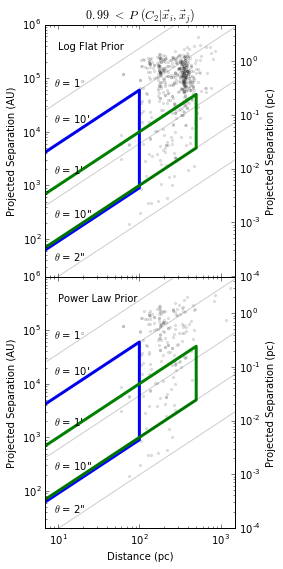

In [254]:
fig, ax = plt.subplots(2, 1, figsize=(4, 8))


tmp_x = 10**np.linspace(0.1,3.5,100)
tmp_y_2as = 2. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_10as = 10. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_60as = 60. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_600as = 600. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_1deg = (np.pi/180.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_10deg = 10.0 * (np.pi/180.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)


# Log flat
for i in np.arange(len(TGAS_log_flat_good)):
    if np.any(str(TGAS_log_flat_good[i]['source_ID_1']) == idx_log_flat) or np.any(str(TGAS_log_flat_good[i]['source_ID_2']) == idx_log_flat):
        ax[0].scatter(TGAS_log_flat_good['distance'][i], TGAS_log_flat_good['proj_sep'][i], marker='.', color='k', alpha=0.1, rasterized=True)

# Power law
for i in np.arange(len(TGAS_power_law_good)):
    if np.any(str(TGAS_power_law_good[i]['source_ID_1']) == idx_power_law) or np.any(str(TGAS_power_law_good[i]['source_ID_2']) == idx_power_law):
        ax[1].scatter(TGAS_power_law_good['distance'][i], TGAS_power_law_good['proj_sep'][i], marker='.', color='k', alpha=0.1, rasterized=True)






x_region = np.array([0.01, 100.0, 100.0, 0.01])
y_region = 600. * (np.pi/180.0/3600.0) * x_region * (c.pc_to_cm/c.AU_to_cm)
y_region[2] = 0.9*10. * (np.pi/180.0/3600.0) * x_region[2] * (c.pc_to_cm/c.AU_to_cm) 
y_region[3] = 0.9*10. * (np.pi/180.0/3600.0) * x_region[3] * (c.pc_to_cm/c.AU_to_cm) 
for i in np.arange(2):
    ax[i].plot(x_region, y_region, color='b', linewidth=3.0, linestyle='solid')

    
x_region = np.array([0.01, 500.0, 500.0, 0.01])
y_region = 100. * (np.pi/180.0/3600.0) * x_region * (c.pc_to_cm/c.AU_to_cm)
y_region[2] = 10. * (np.pi/180.0/3600.0) * x_region[2] * (c.pc_to_cm/c.AU_to_cm)
y_region[3] = 10. * (np.pi/180.0/3600.0) * x_region[3] * (c.pc_to_cm/c.AU_to_cm)
for i in np.arange(2):
    ax[i].plot(x_region, y_region, color='g', linewidth=3.0, linestyle='solid')




for i in np.arange(2):

        ax[i].plot(tmp_x, tmp_y_2as, color='k', linestyle='solid', alpha=0.2)
        ax[i].text(9.0, 40., r'$\theta$ = 2"')
        ax[i].plot(tmp_x, tmp_y_10as, color='k', linestyle='solid', alpha=0.2)
        ax[i].text(9.0, 250., r'$\theta$ = 10"')
        ax[i].plot(tmp_x, tmp_y_60as, color='k', linestyle='solid', alpha=0.2)
        ax[i].text(9.0, 1700., r"$\theta$ = 1'")
        ax[i].plot(tmp_x, tmp_y_600as, color='k', linestyle='solid', alpha=0.2)
        ax[i].text(9.0, 15000., r"$\theta$ = 10'")
        ax[i].plot(tmp_x, tmp_y_1deg, color='k', linestyle='solid', alpha=0.2)
        ax[i,].text(9.0, 7.0e4, r"$\theta$ = 1$^{\circ}$")

        ax[i].set_xlim(7.0, 1500.0)
        ax[i].set_ylim(20.0, 1.0e6)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')

        ax[i].set_xlabel("Distance (pc)")
    

ax2 = ax[0].twinx()
y2_min = ax[0].get_ylim()[0] * c.AU_to_cm/c.pc_to_cm
y2_max = ax[0].get_ylim()[1] * c.AU_to_cm/c.pc_to_cm
ax2.set_ylim(y2_min, y2_max)
ax2.set_yscale('log')
ax2.set_ylabel('Projected Separation (pc)')

ax3 = ax[1].twinx()
y3_min = ax[1].get_ylim()[0] * c.AU_to_cm/c.pc_to_cm
y3_max = ax[1].get_ylim()[1] * c.AU_to_cm/c.pc_to_cm
ax3.set_ylim(y3_min, y3_max)
ax3.set_yscale('log')
ax3.set_ylabel('Projected Separation (pc)')


ax[1].text(10.0, 3.5e5, "Power Law Prior")
ax[0].text(10.0, 3.5e5, "Log Flat Prior")




ax[0].set_ylabel("Projected Separation (AU)")
ax[1].set_ylabel("Projected Separation (AU)")

ax[0].set_title(r'$0.99\ <\ P\ (C_2 | \vec{x}_i, \vec{x}_j)$')


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('../figures/TGAS_dist_s_theta_multiple.pdf')
# plt.show()

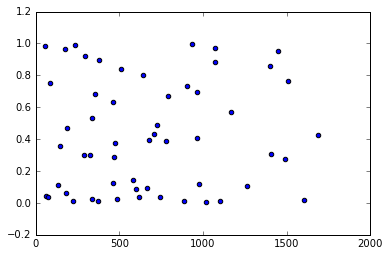

In [145]:
ratio = np.min(triple_angles.T, axis=0) / np.max(triple_angles.T, axis=0)

plt.scatter(np.max(triple_angles.T, axis=0), ratio)
plt.xlim(0, 2000)
# plt.ylim(0, 1600)

# plt.plot([0.0, 2000.0], [0.0, 2000.0], color='k')

# plt.gca().set_aspect('equal', adjustable='box')
plt.show()

angle_min = np.zeros(len(triple_angles))
angle_max = np.zeros(len(triple_angles))

for i, angle in zip(np.arange(len(triple_angles)), triple_angles):
    angle_min[i] = np.min([angle['theta_1'], angle['theta_2'], angle['theta_3']])
    angle_max[i] = np.max([angle['theta_1'], angle['theta_2'], angle['theta_3']])

    
plt.scatter(angle_max, angle_min)

plt.xlim(0.0, 1400)
plt.ylim(0.0, 1400)

plt.show()

In [15]:
print triple_pairs
print
print quad_pairs
print
print quint_pairs

[]

[]

[]


In [19]:
for i in np.arange(len(TGAS_good)):
    print TGAS_good[i]['mu_ra_1'], TGAS_good[i]['mu_dec_1'], TGAS_good[i]['plx_1']

21.7213497823 -34.2291525182 3.37970135266
33.1987044974 -22.9906810827 2.90354506924
34.9555033702 0.745237679416 4.55273042941
0.622408622179 7.0884802395 3.17169601185
19.4789707037 2.91844666281 4.48402686181
19.4789707037 2.91844666281 4.48402686181
19.4789707037 2.91844666281 4.48402686181
49.0104481484 -12.9962556587 7.74134071428
-10.6270897932 -5.81135306586 2.95487085528
82.2203814814 18.1521921254 10.4412651736
10.4696495647 -16.3192742249 1.69537251563
30.8695455119 -13.7631503297 6.27624710773
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
17.5748530158 3.5463004555 4.14707417093
20.1391653294 2.0401390724 3.91872688154
20.1391653294 2.0401390724 3.91872688154
20.1391653294 2.0401390724 3.91872688154
20.1391653294 2.0401390724 3.91872688